In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from adjustText import adjust_text

In [2]:
from scipy import stats
from statsmodels.stats import multitest
def test_sig(x, y):
    if stats.shapiro(x).pvalue >= 0.05 and stats.shapiro(y).pvalue >= 0.05: #if they are normally distriuted
        print("t-test")
        return stats.ttest_ind(x,y)
    else:
        print("mann-whitney")
        return stats.mannwhitneyu(x, y)
def test_mannwhit(x, y):
    return stats.mannwhitneyu(x, y)
def test_ttest(x, y):
    return stats.ttest_ind(x, y)
def test_fdr(x):
     return multitest.fdrcorrection(x, alpha=0.05, method='indep', is_sorted=False)

In [3]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"    
    elif pvalue <= 0.05:
        return "*"
    return ""

def convert_FDR_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "*****"
    elif pvalue <= 0.001:
        return "****"
    elif pvalue <= 0.01:
        return "***"
    elif pvalue <= 0.05:
        return "**"    
    elif pvalue <= 0.1:
        return "*"
    return ""

In [6]:
# Read cytokine data from excel file
# data = pd.read_excel('cytokine-data.xlsx')

In [8]:
data['Vaccine'] = data['Vaccine'].str.replace('PFIZER', 'Pfizer')

In [9]:
data['Unnamed: 1'] = data['Unnamed: 1'].str.replace('Day 1', 'V1D1')
data['Unnamed: 1'] = data['Unnamed: 1'].str.replace('Day 7', 'V1D7')
data['Unnamed: 1'] = data['Unnamed: 1'].str.replace('BL2', 'V2BL')
data['Unnamed: 1'] = data['Unnamed: 1'].str.replace('Day 27', 'V2D1')
data['Unnamed: 1'] = data['Unnamed: 1'].str.replace('Day 35', 'V2D7')

In [10]:
data.sort_values(by=['Unnamed: 1','Vaccine'],inplace=True)

In [15]:
genes=['CXCL10','CCL2','IFNg 3rd gen','IL-10','IL-8','TNF-a 2nd gen']
for i in genes:
    data[i] = pd.to_numeric(data[i], errors='coerce')

data = data.fillna(0)
data['donor'] = data['Sample'].str.split('V',expand=True)[0].str.strip()
data = data.rename(columns={'Unnamed: 1':'Visit'})

In [22]:
gene_name='CXCL10'

# CXCL10 
ysetlim1=0;ysetlim2=350;ysetlim3=1000
# IFNg 3rd gen
# ysetlim1=0;ysetlim2=80;ysetlim3=200
# IL-8
# ysetlim1=0;ysetlim2=6;ysetlim3=25
# TNF-a
# ysetlim1=0;ysetlim2=10;ysetlim3=25
# CCL2
# ysetlim1=0;ysetlim2=8

In [23]:
dfm_rna = data[['Visit',gene_name,'donor','Vaccine']]

In [26]:
color_pallete=['#299C0C','#1494D9','#D91432']

/tmp/ipykernel_1077632/954121451.py:64: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.lineplot(x='x', y='y', data=combine_off, hue='sub',
/tmp/ipykernel_1077632/954121451.py:80: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.lineplot(x='x', y='y', data=combine_off, hue='sub',


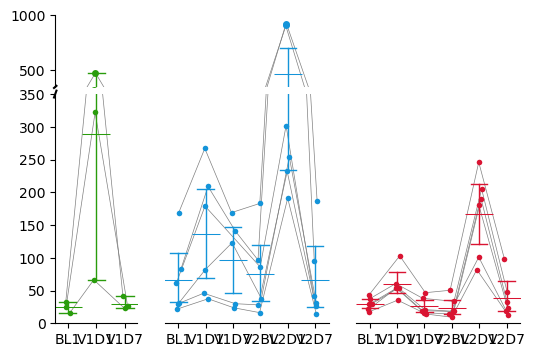

In [28]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(6, 4))
outer = gridspec.GridSpec(1, 3, wspace=0.2, hspace=0.2,
                          width_ratios=[3,6,6])

max_y=dfm_rna[gene_name].max()
min_y=dfm_rna[gene_name].min()
    
for i in range(3):
    inner = gridspec.GridSpecFromSubplotSpec(4, 1,
                    subplot_spec=outer[i], wspace=0.05, hspace=0.1)

    vaccine_type=['J&J', 'Moderna', 'Pfizer']
    dfm_temp = dfm_rna[dfm_rna.Vaccine == vaccine_type[i]]
    dfm_temp = dfm_temp.dropna()
    dfm_baseline = dfm_temp[dfm_temp['Visit'] == 'BL1'].reset_index(drop=True)
    dfm_temp.sort_values(['Visit','donor'], inplace=True)
    pvalues = dict()
    for x in dfm_temp['Visit'].unique():
        if 'BL1' not in x:
            try:
                stat, pvalue = test_wilcoxon(
                    dfm_temp[dfm_temp['Visit'] == x][gene_name].astype(float),
                    dfm_baseline[gene_name].astype(float)
                )
                pvalues[x] = pvalue
            except:
                pvalues[x] = 1
    
    ax = plt.Subplot(fig, inner[0]) # Bottom
    ax2 = plt.Subplot(fig, inner[1:4])  # Top

    strip = sns.stripplot(x='Visit', 
                          y=gene_name, 
                          data=dfm_temp, 
                          jitter=True, 
                          color=color_pallete[i],
                          size=5, 
                          legend=False, 
                          ax = ax,
                          )

    strip2 = sns.stripplot(x='Visit', y=gene_name, data=dfm_temp, 
                          jitter=True, 
                          color=color_pallete[i], 

                          size=4, 
                          legend=False, 
                          ax = ax2
                          )

    combine_off = []
    collections = strip.collections
    for col in collections:
        offsets = col.get_offsets()
        plot_data = pd.DataFrame(offsets, columns=['x', 'y'])
        plot_data = plot_data.sort_values('y')
        combine_off.append(plot_data)
    combine_off = pd.concat(combine_off).reset_index(drop=True)
    combine_off['sub'] = dfm_temp['donor'].values
    
    sns.lineplot(x='x', y='y', data=combine_off, hue='sub', 
                 legend=False, palette=['grey'] * 6, #
                 markers=False, linewidth=0.5, ax = ax
                )


    combine_off = []
    collections = strip2.collections
    for col in collections:
        offsets = col.get_offsets()
        plot_data = pd.DataFrame(offsets, columns=['x', 'y'])
        plot_data = plot_data.sort_values('y')
        combine_off.append(plot_data)
    combine_off = pd.concat(combine_off).reset_index(drop=True)
    combine_off['sub'] = dfm_temp['donor'].values
    
    sns.lineplot(x='x', y='y', data=combine_off, hue='sub', 
                 legend=False, palette=['grey'] * 6, #
                 markers=False, linewidth=0.5, ax = ax2
                )


    
    sns.pointplot(data=dfm_temp, x="Visit",
            y=gene_name,
            errorbar=("ci", 95),
            capsize=.6, 
            markersize=20,
            color=color_pallete[i],
            linestyle="none", 
            linewidth=1,
            marker="_", ax=ax
            )


    sns.pointplot(data=dfm_temp, x="Visit",
            y=gene_name,
            errorbar=("ci", 95), 
            capsize=.6, 
            markersize=20,
            color=color_pallet[i], 
            linestyle="none", 
            linewidth=1,
            marker="_",
            ax=ax2
            )

    ax.set_ylim(ysetlim2, ysetlim3)  # outliers only
    ax2.set_ylim(ysetlim1, ysetlim2)  # most of the data

    # Make the two subplot combine
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax.xaxis.set_ticks([])
    ax.xaxis.tick_top()
    ax.tick_params(labeltop=False)  # don't put tick labels at the top
    ax2.xaxis.tick_bottom()
    
    if i == 0:
        d = .015 
        kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
        ax.plot((-d, +d), (-d, +d), **kwargs)  
        
        kwargs.update(transform=ax2.transAxes)
        ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
    
    ax.set_ylabel('') 
    ax2.set_ylabel('') 
    ax.set_xlabel('') 
    ax2.set_xlabel('') 

    ax.spines['right'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    
    if i > 0:
        ax.yaxis.set_ticks([])
        ax2.yaxis.set_ticks([])
        ax.spines['left'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    fig.add_subplot(ax)
    fig.add_subplot(ax2)

fig.show()